***Introduction*** 

We were tasked with finding the objectively best neighborhood in Pittsburgh. To do this, we used data from the WPRDC, which stands for the Western Pennsylvania Regional Data Center. The website collects large amounts data on Pittsburgh and the surrounding area. We used these datasets to determine objectively what the best neighborhood was. But, first we had to define a metric for what the best neighborhood looks like. In order to find the best metric, we combed through the datasets and found which ones could be used to determine what the best neighborhood is. This lead us to developing that the best neighborhood is the cleanest and most fun.

------

***The Metric***

The metric we came up with to define "bestness" was density of smart trashcans and playgrounds in a given neighborhood. To determine this objectively, we used three datasets from the WPRDC: 
* Smart Trash Containers
* City of Pittsburgh Playgrounds
* Pittsburgh Neighborhoods

We used the Smart Trash Containers dataset to locate and count the number of smart trash containers per neighborhood. Smart trash containers are trash cans that determine how much trash is currently in them and sends that to the public works employees so that they can empty them. The City of Pittsburgh Playgrounds data set was used in the same way as the Smart Trash Containers dataset to locate and count the number of playgrounds in a neighborhood. The final dataset we used was the Pittsburgh Neighborhoods dataset which provided general information about neighborhoods, such as population and square milage. We used the square milage of neighborhoods to balance out the neighborhoods, becuase smaller neighborhoods would have less space and therefore less opportunity to build playgrounds or employ smart trash containers. To determine the best overall neighborhood we used a scoring system that gave points to the top 20 in each category based on how well they did. If a neighborhood did not finish in the top 20, then they got zero points, so the best neighborhood had to have a balance of both smart trash containers and playgrounds. 

-----

***Data Behind Determining the Best Neighborhood***

Our datasets required a lot of cleaning which is all done in this section.

In [4]:
# Imports
import pandas as pd
import numpy as np
import ssl
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# Loading Data into Jupyterhub
pgh_trash_data = pd.read_csv("https://data.wprdc.org/datastore/dump/75b83ac9-8069-4cf1-bcc3-b9e6b04487d9")
pgh_neighborhood_data = pd.read_csv("http://pghgis-pittsburghpa.opendata.arcgis.com/datasets/dbd133a206cc4a3aa915cb28baa60fd4_0.csv")
pgh_park_data = pd.read_csv("https://data.wprdc.org/datastore/dump/47350364-44a8-4d15-b6e0-5f79ddff9367")

# Organize Data by neighborhood
trash_by_neighborhood = pgh_trash_data['neighborhood'].value_counts()
pgh_sqmiles = pgh_neighborhood_data['sqmiles']
pgh_hoods = pgh_neighborhood_data['hood']
park_by_neighborhood = pgh_park_data['neighborhood'].value_counts()

# Convert Series to Dataframe
trash_by_neighborhood_frame = trash_by_neighborhood.to_frame()
pgh_sqmiles_frame = pgh_sqmiles.to_frame()
pgh_hoods_frame = pgh_hoods.to_frame()
park_by_neighborhood_frame = park_by_neighborhood.to_frame()

# Rename columns to allow for merging
trash_by_neighborhood_frame.reset_index(inplace=True)
trash_by_neighborhood_frame.rename(columns = {'index':'hood', 'neighborhood':'trash_cans'}, inplace=True)
park_by_neighborhood_frame.reset_index(inplace=True)
park_by_neighborhood_frame.rename(columns = {'index':'hood', 'neighborhood':'parks'}, inplace=True)

# Merge data togehter
sqmiles_by_neighborhood = pgh_hoods_frame.join(pgh_sqmiles_frame)
trash_and_sqmiles_by_hood = pd.merge(sqmiles_by_neighborhood, trash_by_neighborhood_frame)
park_and_sqmiles_by_hood = pd.merge(sqmiles_by_neighborhood, park_by_neighborhood_frame)

# Calculate the ratio of trash cans per square mile
data = trash_and_sqmiles_by_hood['trash_cans'] / trash_and_sqmiles_by_hood['sqmiles']
data_frame = data.to_frame()
data_frame.columns = ['ratio']
overall_data = trash_and_sqmiles_by_hood.join(data_frame)
overall_data.rename(columns = {'Unnamed':'ratio'}, inplace=True)
overall_data = overall_data.set_index('hood')

# Calculate the ratio of parks per square mile
data_2 = park_and_sqmiles_by_hood['parks'] / park_and_sqmiles_by_hood['sqmiles']
data_frame_2 = data_2.to_frame()
data_frame_2.columns = ['ratio']
overall_data_2 = park_and_sqmiles_by_hood.join(data_frame_2)
overall_data_2.rename(columns = {'Unnamed':'ratio'}, inplace=True)
overall_data_2 = overall_data_2.set_index('hood')

# Filter
    # Filtering ratios
trimmed_data = overall_data[overall_data.ratio >= 41]
trimmed_data = trimmed_data.sort_values(by='ratio')
trimmed_data_2 = overall_data_2[overall_data_2.ratio >= 4.35]
trimmed_data_2 = trimmed_data_2.sort_values(by='ratio')

    # Filtering trash can totals
trimmed_trash = trash_by_neighborhood_frame[trash_by_neighborhood_frame.trash_cans >= 34]
trimmed_trash = trimmed_trash.sort_values(by='trash_cans')
trimmed_trash = trimmed_trash.set_index('hood')

    # Filtering square milage
trimmed_sqmiles = sqmiles_by_neighborhood[sqmiles_by_neighborhood.sqmiles >= 1.1]
trimmed_sqmiles = trimmed_sqmiles.sort_values(by='sqmiles')
trimmed_sqmiles = trimmed_sqmiles.set_index('hood')

-----

***Determining the Best Neighborhood***

Here are the top 20 neighborhoods by category:

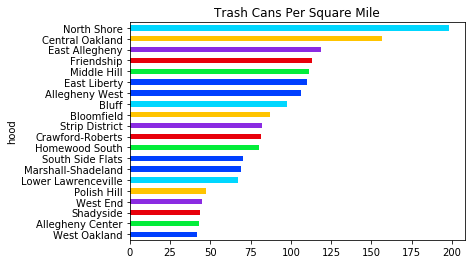

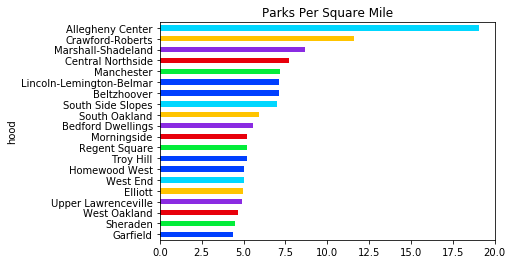

In [7]:
plt.style.use('seaborn-bright')
    # List of Ratios of Trash Cans per Square Mile
trimmed_data['ratio'].plot.barh(title='Trash Cans Per Square Mile')
plt.show()
    # List of Ratios of Parks per Square Mile
trimmed_data_2['ratio'].plot.barh(title='Parks Per Square Mile')
plt.show()

-----

To determine the overall best neighborhood, we created a scoring system where first place got 20 points, second place got 19 points, third place got 18 points, etc. Those results are presented below. We then combined those results into one data set and added their scores together to determine the overall best neighborhood.

In [9]:
#Scoring System
trimmed_data = trimmed_data.assign(score = ['1','2','3','4','5','6','7','8','9','10',
                                            '11','12','13','14','15','16','17','18','19','20'])
trimmed_data_2 = trimmed_data_2.assign(score = ['1','2','3','4','5','6','7','8','9','10',
                                                '11','12','13','14','15','16','17','18','19','20'])
pd.merge(trimmed_data, trimmed_data_2, on='hood', how='outer')

#Calculation of combined score
combined_data = pd.merge(trimmed_data, trimmed_data_2, on='hood', how='outer')
combined_data.fillna(0, inplace=True)
combined_data['score_x'] = combined_data['score_x'].astype(int)
combined_data['score_y'] = combined_data['score_y'].astype(int)
combined_data = combined_data.assign(combined_score = combined_data['score_x'] + combined_data['score_y'])
top_10 = combined_data[combined_data.combined_score >= 16]

-----

The Top 10 Neighborhoods are listed below

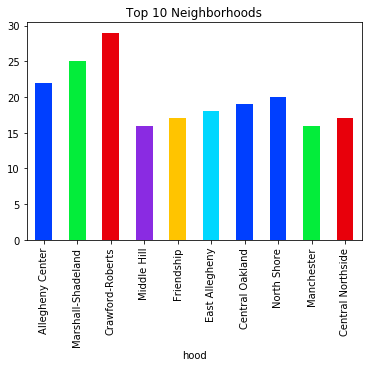

In [10]:
top_10['combined_score'].plot.bar(title='Top 10 Neighborhoods')

-----

***The Best Neighborhood***

As you can see Crawford-Roberts is the best neighborhood. It was eleventh in Trash Cans per Square Mile and second in Playgrounds per Square Mile. Earning it the title of "Best Neighborhood in Pittsburgh."

-----

***Conclusions***

* Connor - The data driven approach is objective, but it only took into account two factors. My personal favorite neighborhood is Morningside (where I grew up) not because it is the safest or has the most parks. It's just a small quiet neighborhood with a great community. None of those factors can be taken into account by datasets. I believe both ways of thinking are valid, because it is impossible to objectify things like sense of community.

* Joel - The data driven determination of the best neighborhood only looked at two components, which other people may not see as being important when deciding which neighborhood is best. Since I'm not from Pittsburgh and do not know that many neighborhoods, my favorite has to be Oakland. It's my new home for the next couple years and it's serving me well. Sorting through datasets can be a reasonable way to choose which neighborhood is the best one, but datasets can't describe the feelings one has towards a certain place or the pride of a neighborhood.

* James - Deciding which neighborhood is the best in all of Pittsburgh based off of only two main factors may not be super reliable. I have not personally had the time to see many different neighborhoods around the city, so my personal favorite would have to be Oakland, as I am the most familiar with it and it has been a great home so far. However, I may have to visit Crawford-Roberts for myself to see just how clean and fun it is.